%%latex
\tableofcontents 
\setcounter{section}{0}

# Load the results

In [66]:
def import_calc_dF(name):
    path  = f'./data/{name}'
    dF = pd.read_hdf(path)
    display(dF)
    grain_size = dF.iloc[0]['R']
    DIFF_EF_EC_evolt = dF.iloc[0]['DIFF_EF_EC_evolt']
    temp = dF.iloc[0]['temp']
    print(grain_size, temp,DIFF_EF_EC_evolt)
    material = Material(T_C=temp,DIFF_EF_EC_evolt=DIFF_EF_EC_evolt)
    grain = Grain(grain_size,material)
    return grain, dF
    

grain2, dF_calc2 = import_calc_dF(name)


,E_dor_init_kT,Einit_kT,res,R,temp,DIFF_EF_EC_evolt
-8,-59.827508,-8.0,1.267668,1.000000e-07,300,0.316354
-4,-8.793280,-4.0,0.452107,1.000000e-07,300,0.316354
-2,-2.309865,-2.0,0.119488,1.000000e-07,300,0.316354
-1,-0.846746,-1.0,0.083006,1.000000e-07,300,0.316354
0,0.000000,0.0,0.000000,1.000000e-07,300,0.316354
1,0.462643,1.0,0.041065,1.000000e-07,300,0.316354
2,0.692803,2.0,0.055365,1.000000e-07,300,0.316354
4,0.836355,4.0,0.126297,1.000000e-07,300,0.316354
8,0.860993,8.0,0.171876,1.000000e-07,300,0.316354


1e-07 300.0 0.3163543980626456


,E_dor_init_kT,Einit_kT,res,R,temp,DIFF_EF_EC_evolt,eV_init
-8,-59.827508,-8.0,1.267668,1.000000e-07,300,0.316354,-0.395122
-4,-8.793280,-4.0,0.452107,1.000000e-07,300,0.316354,-0.197561
-2,-2.309865,-2.0,0.119488,1.000000e-07,300,0.316354,-0.098780
-1,-0.846746,-1.0,0.083006,1.000000e-07,300,0.316354,-0.049390
0,0.000000,0.0,0.000000,1.000000e-07,300,0.316354,0.000000
1,0.462643,1.0,0.041065,1.000000e-07,300,0.316354,0.049390
2,0.692803,2.0,0.055365,1.000000e-07,300,0.316354,0.098780
4,0.836355,4.0,0.126297,1.000000e-07,300,0.316354,0.197561
8,0.860993,8.0,0.171876,1.000000e-07,300,0.316354,0.395122


'Solutions resulting from minizing the error.'

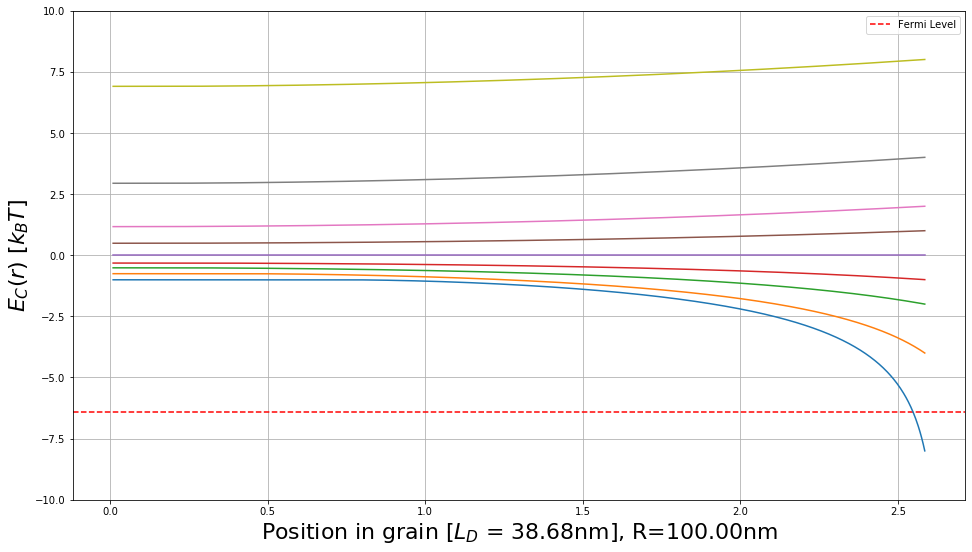

In [67]:
fig, axe= subplots(figsize = (16,9))
temp_grain = grain2
dF_calc_temp = dF_calc2
axe.axhline(-temp_grain.material.J_to_kT(temp_grain.material.Diff_EF_EC),linestyle='--',color='r', label='Fermi Level')
axe.set_ylim(-10,10)

for vinit, ser_temp in dF_calc_temp.iterrows():
    vinit = ser_temp['Einit_kT']
    v_dot_init = ser_temp['E_dor_init_kT']
    resid = ser_temp['res'] 
    

    r,v,vdot, data = temp_grain.solve_with_values(temp_grain.material.kT_to_J(vinit),temp_grain.material.kT_to_J(v_dot_init), )
    r = np.concatenate([[0.01],r], axis=0)
    v = np.concatenate([[v[0]],v], axis=0)
    vdot = np.concatenate([[0],vdot], axis=0)


    axe.plot(r,v, '-', label = "")
    axe.set_ylabel('$E_C(r)$ [$k_BT$]', fontsize =22)
    axe.set_xlabel(f'Position in grain [$L_D$ = {temp_grain.material.LD*1e9:.2f}nm], R={temp_grain.R*1e9:.2f}nm', fontsize =22)
axe.legend()
axe.grid(b=True)
dF_calc['eV_init'] = dF_calc['Einit_kT'].apply(temp_grain.material.kT_to_J).apply(CONST.J_to_eV)
display(dF_calc.sort_index())
"Solutions resulting from minizing the error."

This graph shows how a surface potential is shielded by the remaining ionized donors. In the case of on deletion layer ( $E_{C_{Surface}}>0 )$), the total number of charges shielding the surface potential is rather small compared to the amount of charges in an accumulation layer ( $E_{C_{Surface}}<0 )$). The result of such an asymmetry is visible in the graph. The width of the accumulation layer is by far smaller then the width of the depleted are.

# From charge distribution to resistance

With the previous tools and calculation it is now possible to assign each point inside the grain a certain charge density. From this charge density a specific resistivity can be assinged to this area.
First the ratio of $\frac{n(r)}{n_b}$ inside the grain will be represented for the different starting conditions regarding $E_{C_{Surface}}$.
To evaluate the $n(r)$ at arbitrary points r inside the grain, one additional step is needed. To calculate values between the points, where already solution exist, the additional value can be retrieved by interpolating between the neighbors. This process is generally called interpolation. Again, SciPy and Python offer here also a easy to use and robust solution.
`from scipy import interpolate` adds the `interpolate` module into the kernel. The `interp1d` function of this module is described ([here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.htm)) as follows:
>Interpolate a 1-D function.
>
>x and y are arrays of values used to approximate some function f: y = f(x). This class returns a function whose call method uses interpolation to find the value of new points.

This is how the function will be used for our needs. First we select one of the initial parameters for $E_{init}$ and $E_{dot_{init}}$ to recalculate the solution of the Poisson equation with these correct start parameters. In a second step we use `interp1d` to create a function which uses an interpolation algorithm to find the right value for any position inside the grain.

In [ ]:
from scipy import interpolate

#get some solutions

def get_interpolation_from_solution(ser):
    edot_init_kt = ser['E_dor_init_kT']
    e_init_kt = ser['Einit_kT']
    r,v,vdot, data = grain.solve_with_values(temp_grain.material.kT_to_J(e_init_kt),temp_grain.material.kT_to_J(edot_init_kt), )
    r = np.concatenate([[0.0],r], axis=0)
    v = np.concatenate([[v[0]],v], axis=0)
    vdot = np.concatenate([[0],vdot], axis=0)

    #create a interpolation function to get values between calculated ones
    f = interpolate.interp1d(r*grain.material.LD, grain.material.kT_to_J(v))
    return f

    
ser = dF_calc.iloc[1]
f = get_interpolation_from_solution(ser)
#try one position
pos = 80*1e-9
c = grain.material.n(float(f(pos)))[0]/grain.material.nb

print(f"""For a inital E_init of {e_init_kt:.2f}kT, the free charge carriers density\n
      in the conduction band at {pos*1e9:.2f}nm from the center in utits of nb is: {c:.2f}""")


This means in the accumulation layer there are a the specific position 5.39 times more free charge carriers available as in the center. This results directly in a lower resistivity of the same factor.
Instead of just calculating just individual values, the graphical representation is in this case more helpful.

In [ ]:
           
def pos_to_r(xi,yi,grain, d):
    dx = 2*grain.R/d.shape[0]
    cx = d.shape[0]//2
    cy = d.shape[1]//2
    ri = ((xi-cx)**2+(yi-cy)**2)**0.5
    return(ri*dx)


def create_numerical_grain_matrix( grain, ser,n=100,):
    condus = []
    f = get_interpolation_from_solution(ser)
    nx = ny = n
    d_v = np.zeros((2*nx+1,2*ny+1))
    d_roh = np.zeros((2*nx+1,2*ny+1))
    d_cond = np.zeros((2*nx+1,2*ny+1))
    
    d_mask = np.zeros((2*nx+1,2*ny+1))
    
    cx = d_v.shape[0]//2
    cy = d_v.shape[1]//2


    for xi in range(d_roh.shape[0]):
        for yi in range(d_roh.shape[1]):
            r = float(pos_to_r(xi,yi,grain, d_roh))
            try:
                n = grain.material.n(float(f(r)))[0]/grain.material.nb
                condu = n
                d_roh[xi, yi] = 1/condu
                d_cond[xi, yi] = condu
                d_mask[xi,yi] = 1
                condus.append(condu)

            except ValueError:
                #outside the grain
                d_roh[xi, yi] = 50000
                d_cond[xi, yi] = 0
                d_mask[xi,yi] = 0
    return d_v, d_cond, d_mask

def plot_numerical_grain(axe, grain, ser, n=100):
    d_v, d_cond,d_mask = create_numerical_grain_matrix( grain, ser,n=n)
    d_cond_plot = d_cond.copy()
    d_cond_plot[np.where(d_mask==0)]=None
    im = axe.imshow(np.log(d_cond_plot), interpolation='bicubic',extent=(-grain.R*1e9, grain.R*1e9, -grain.R*1e9, grain.R*1e9),cmap='hot')
    axe.set_ylabel('x [nm]')
    axe.set_xlabel('y [nm]')
    return d

fig, axes = subplots(3,3, figsize = (16,9))
for ax_i, (vinit, ser) in enumerate(dF_calc.iterrows()):
    axe = fig.axes[ax_i]
    plot_numerical_grain(axe, grain, ser)
    axe.set_title(r'$E_{C_{Surface}}=$'+f'{vinit}kT')
                  
fig.tight_layout()
    




In [ ]:
from scipy import signal


def initaliz_d_v(d_v):
    d_v[:,0] = -1000
    d_v[:,-1] = +1000
    d_v = d_v*d_mask
    return d_v

def solve_relaxation(d_v, d_cond, d_mask):

    for i in range(10000):

        conv = [[0,1,0],[1,0,1],[0,1,0]]
        numerator = signal.convolve2d(d_v*d_cond, conv, boundary='fill', mode='same', fillvalue=0)
        denominator = signal.convolve2d(d_cond, conv, boundary='fill', mode='same', fillvalue=0)
        d_v_new = (numerator/denominator)*d_mask
        d_v_new = np.nan_to_num(d_v_new,0)

        d_v_prev = d_v.copy()
        d_v = d_v_new.copy()
        d_v = initaliz_d_v(d_v)
    return d_v, d_cond, d_mask

def plot_num_grain(d_v, d_cond, d_mask):
    fig, axes =subplots(1,3)
    d_v_plot = d_v.copy()
    d_v_plot[np.where(d_mask==0)]=None

    axes[0].imshow(d_mask)
    axes[1].imshow(d_cond)
    axes[2].imshow(d_v_plot,interpolation= 'nearest')
    
def plot_voltage_1d(d_v):
    fig, axe = subplots()
    center = d_v[d_v.shape[0]//2,:]
    axe.plot(center)

def calc_current_center(d_v, d_cond, d_mask):
    center_pos = d_v.shape[0]//2
    center_current = (d_v[:,center_pos+1]-d_v[:,center_pos-1])*d_cond[:,center_pos]
    
    r = np.array([float(pos_to_r(xi,l,grain, d_v)) for xi in range(len(center_current))])
    
    center_current_tot = np.sum(center_current*r)
    return center_current_tot, center_current, r

def plot_center_current(r, center_current):
    fig, axe = subplots()
    axe.plot(r*1e9,center_current)
    return

#vinit, current = calc_current(d_v, d_cond, d_mask)

In [ ]:
fig, axe = subplots()
axe.plot(d_v[d_v.shape[0]//2,:])

In [ ]:


def initaliz_d_v(d_v):
    d_v[:,0] = -1000
    d_v[:,-1] = +1000
    d_v = d_v*d_mask
    return d_v

for vinit, ser in dF_calc.iterrows():
    vinit = ser.name
    print(vinit)
    d_v, d_cond, d_mask = create_numerical_grain_matrix( grain, ser,n=50,)
    d_v = initaliz_d_v(d_v)

    d_v, d_cond, d_mask = solve_relaxation(d_v, d_cond, d_mask)
    
    center_current_tot, center_current, r = calc_current_center(d_v, d_cond, d_mask)
    
    plot_num_grain(d_v, d_cond, d_mask)
    plot_voltage_1d(d_v)
    plot_center_current(r, center_current)
        
    
    dF_calc.loc[vinit, 'current'] = center_current_tot

In [ ]:
fig, axe = subplots()
axe.plot(1/dF_calc['current'])
axe.set_yscale('log')

In [ ]:
fig, axe = subplots()
axe.plot(1/dF_calc['current'])
axe.set_yscale('log')

In [ ]:
list(zip(r,zz))

In [ ]:
from scipy import signal

def calc_current(d_v, d_cond, d_mask):

    for i in range(10000):

        c = [[0,1,0],[1,0,1],[0,1,0]]
        z = signal.convolve2d(d_v*d_cond, c, boundary='fill', mode='same', fillvalue=0)
        n = signal.convolve2d(d_cond, c, boundary='fill', mode='same', fillvalue=0)
        d_v_new = (z/n)*d_mask
        d_v_new = np.nan_to_num(d_v_new,0)




        d_v_prev = d_v.copy()
        d_v = d_v_new.copy()
        d_v = initaliz_d_v(d_v)

    print((d_v-d_v_prev).sum())
    fig, axes =subplots(1,3)

    d_v_plot = d_v.copy()
    d_v_plot[np.where(d_mask==0)]=None

    axes[0].imshow(d_mask)
    axes[1].imshow(d_roh)
    axes[2].imshow(d_v_plot,interpolation= 'nearest')

    fig, axe = subplots()
    center = d_v[d_v.shape[0]//2,:]
    axe.plot(center)

    l = d_v.shape[0]//2
    zz = (d_v[:,l+1]-d_v[:,l-1])*d_cond[:,l]
    r = np.array([float(pos_to_r(xi,l,grain, z)) for xi in range(len(zz))])
    print(vinit, np.sum(zz*r)*1e9)
    fig, axe = subplots()
    axe.plot(r*1e9,zz)
    return vinit, np.sum(zz*r)*1e9
vinit, current = calc_current(d_v, d_cond, d_mask)

In [ ]:
8 15.849051335712266
-8 2935778.4102546293

In [ ]:
fig, axe = subplots()
axe.plot(j_slice)

In [ ]:
c = [[0,0,0],[-1,0,1],[0,0,0]]
z = signal.convolve2d(d_v, c, boundary='fill', mode='same', fillvalue=0)
z = z*d_cond
fig, axe = subplots( sharex=True)

z[np.where(d_mask==0)]=None
axe.imshow(z)

fig, axe = subplots()
slaps = []
poss = []
for l in range(z.shape[0]):
    try:
        zz = (d_v[:,l+1]-d_v[:,l-1])*d_cond[:,l]
        r = [float(pos_to_r(xi,l,grain, z)) for xi in range(len(zz))]
        j_slice = np.abs(np.nan_to_num(zz,0))
        s = np.trapz(j_slice*r, r)
        #s = np.sum(np.nan_to_num(tot_j_slice,0))
        slaps.append(s)
        poss.append(l)
    except:
        pass
axe.plot(poss,slaps/min(slaps), 'ro')
print(slaps[])

In [ ]:
r

In [ ]:
fig, axe = subplots()
zz = (d_v[0:z.shape[0]//2,49]-d_v[0:z.shape[0]//2,51])*d_cond[0:z.shape[0]//2,49]
zz = np.abs(zz)
axe.plot(r,zz)
#axe.plot(r,z)
print(np.trapz(zz*2*pi,r))

# Bibliography section

%%latex
\bibliographystyle{alphadin}
\bibliography{ipython}